# QA Phantom Analysis

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom

from mriqa.phantoms import phantom_mask_2d, find_phantom, TO2
from mriqa.dcmio import fetch_series, approx_slice_orientation, approx_phase_orientation
from mriqa.tools import mean_im, diff_im, snr_im, snr, show_mosaic

from IPython.core.display import display

The TO2 phantom has a 120mm square box for distortion measurements. Here we use this to estimate the in plane scale (aka *linearity*) and the relative distortion as described in the IPEM Report 80 *green book*. We use the 3mm slice series for this and we choose a slice in the middle of the block. 

After centring the phantom we extract an ROI for the box using its expected position in the phantom. The central area is occupied by the wedges and plates so we fill this with the phantom background intensity so it doesn't interfere with profiles acorss othe ROI.

Then, to get smoother and more easily locatable peaks in the profiles we interpolate the image to higher resolution using the `scipy` image `zoom` function. 

## Distortion on TO2

In [2]:
def distortion_report(dobj, frame=None, flipped_ud=False, flipped_rl=False):
    '''Takes a dicom object which is a single slice around the middle of the phantom TO2.
       Plots the image with the distortion box positions marked on, the extracted ROI with the profiles marked on
       and the estinated values for the image scaling and distortion based on the 120mm square in TO2.
    '''
    # Get image data and reorient if need be

    # Handle multiframes
    if 'NumberofFrames' in dobj and dobj.NumberofFrames > 1:
        if frame is None:
            frame = dobj.NumberofFrames//2
        image = dobj.pixel_array[frame] & 0xfff
        pixel_spacing = dobj.PerframeFunctionalGroups[0].PixelMeasures[0].PixelSpacing
        slice_thickness = dobj.PerframeFunctionalGroups[0].PixelMeasures[0].SliceThickness
    else:
        pixel_spacing = dobj.PixelSpacing
        slice_thickness = dobj.SliceThickness
        image = dobj.pixel_array & 0xfff

    if flipped_ud:
        image = np.flipud(image)
    if flipped_rl:
        image = np.fliplr(image)

    pix_dims = np.asarray(pixel_spacing)
    
    # Plotting area
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.subplots_adjust(wspace=0.5)

    # Show phantom image
    axes[0].imshow(image, cmap='bone')
    axes[0].axis('off')
    axes[0].axis('image')
    
    # Find centre of phantom
    expected_radius = TO2['Diameter'] / 2 / pix_dims[0]
    centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

    # Positions of distortion box
    box     = TO2['Features']['Boxes'][0]
    boxsize = TO2['FeatureSizes']['Boxes'][0]

    # Outer bounding rectangle for distortion box
    (x, y), (dx, dy) = np.array(box) / pix_dims
    x += centre_x
    y += centre_y
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, fill=False, edgecolor='r'))
    
    # Inner bounding rectangle for distortion box
    (x, y), (dx, dy) = (np.array(box) + [[boxsize, boxsize], [-2*boxsize, -2*boxsize]]) / pix_dims
    x += centre_x
    y += centre_y
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, fill=False, edgecolor='r'))

    # Outer bounding rectangle for distortion box to select ROI
    (x, y), (dx, dy) = np.array(box) / pix_dims
    x += centre_x
    y += centre_y
    box_roi = image[y:y+dy+1,x:x+dx+1].copy()

    axes[0].set_title('%s' % dobj.ProtocolName)

    # Inner bounding rectangle for distortion box to foreground fill
    margin_x, margin_y = np.array([boxsize, boxsize]) / pix_dims
    fill_value = (
        np.mean(box_roi[ margin_y, margin_x:-margin_x]) +
        np.mean(box_roi[-margin_y, margin_x:-margin_x]) +
        np.mean(box_roi[margin_y:-margin_y,  margin_x]) +
        np.mean(box_roi[margin_y:-margin_y, -margin_x])
    ) / 4
    box_roi[margin_y:-margin_y, margin_x:-margin_x] = fill_value

    # Interpolate up for smooth profiles
    zoom_factor = 4
    box_roi = zoom(box_roi, zoom_factor)
    pix_dims = pix_dims / zoom_factor

    # Show Region of Interest
    axes[1].imshow(box_roi, cmap='bone')
    axes[1].axis('off')
    axes[1].axis('image')

    # Horizontal profiles (inverted)
    row_h1 = box_roi.shape[0]//4
    profile_h1 = np.mean(box_roi[row_h1-1:row_h1+2,:], axis=0)
    profile_h1 = profile_h1[len(profile_h1)//2] - profile_h1

    row_h2 = box_roi.shape[0]//2
    profile_h2 = np.mean(box_roi[row_h2-1:row_h2+2,:], axis=0)
    profile_h2 = profile_h2[len(profile_h2)//2] - profile_h2

    row_h3 = 3 * box_roi.shape[0]//4
    profile_h3 = np.mean(box_roi[row_h3-1:row_h3+2,:], axis=0)
    profile_h3 = profile_h3[len(profile_h3)//2] - profile_h3

    # Overlay horizontal profiles on ROI image
    im_height = box_roi.shape[0]
    profile_height = np.max(profile_h1)
    axes[1].plot(row_h1 - profile_h1/profile_height * im_height/10)
    axes[1].plot(row_h2 - profile_h2/profile_height * im_height/10)
    axes[1].plot(row_h3 - profile_h3/profile_height * im_height/10)

    # Horizontal Separations
    profile_len = len(profile_h1)
    d_h1a = np.argmax(profile_h1[:profile_len//4])
    d_h1b = np.argmax(profile_h1[-profile_len//4:])
    dist_h1_pix = (d_h1b + profile_len - profile_len//4 - d_h1a)
    dist_h1_mm  = dist_h1_pix * pix_dims[1]

    d_h2a = np.argmax(profile_h2[:profile_len//4])
    d_h2b = np.argmax(profile_h2[-profile_len//4:])
    dist_h2_pix = (d_h2b + profile_len - profile_len//4 - d_h2a)
    dist_h2_mm  = dist_h2_pix * pix_dims[1]

    d_h3a = np.argmax(profile_h3[:profile_len//4])
    d_h3b = np.argmax(profile_h3[-profile_len//4:])
    dist_h3_pix = (d_h3b + profile_len - profile_len//4 - d_h3a)
    dist_h3_mm  = dist_h3_pix * pix_dims[1]
    
    text_delta = profile_len / 30
    axes[1].text(d_h1a + text_delta, row_h1 - text_delta, '%0.2f' % dist_h1_mm)
    axes[1].text(d_h2a + text_delta, row_h2 - text_delta, '%0.2f' % dist_h2_mm)
    axes[1].text(d_h3a + text_delta, row_h3 - text_delta, '%0.2f' % dist_h3_mm)
    
    # Vertical profiles (inverted)
    col_v1 = box_roi.shape[1]//4
    profile_v1 = np.mean(box_roi[:, col_v1-1:col_v1+2], axis=1)
    profile_v1 = profile_v1[len(profile_v1)//2] - profile_v1

    col_v2 = box_roi.shape[1]//2
    profile_v2 = np.mean(box_roi[:, col_v2-1:col_v2+2], axis=1)
    profile_v2 = profile_v2[len(profile_v2)//2] - profile_v2

    col_v3 = 3*box_roi.shape[1]//4
    profile_v3 = np.mean(box_roi[:, col_v3-1:col_v3+2], axis=1)
    profile_v3 = profile_v3[len(profile_v3)//2] - profile_v3
    
    # Overlay vertical profiles on ROI image
    im_width = box_roi.shape[1]
    profile_height = np.max(profile_v1)
    axes[1].plot(col_v1 + profile_v1/profile_height * im_width/10, range(len(profile_v1)))
    axes[1].plot(col_v2 + profile_v2/profile_height * im_width/10, range(len(profile_v2)))
    axes[1].plot(col_v3 + profile_v3/profile_height * im_width/10, range(len(profile_v3)))

    # Vertical Separations
    profile_len = len(profile_v1)
    d_v1a = np.argmax(profile_v1[:profile_len//4])
    d_v1b = np.argmax(profile_v1[-profile_len//4:])
    dist_v1_pix = (d_v1b + profile_len - profile_len//4 - d_v1a)
    dist_v1_mm  = dist_v1_pix * pix_dims[0]

    d_v2a = np.argmax(profile_v2[:profile_len//4])
    d_v2b = np.argmax(profile_v2[-profile_len//4:])
    dist_v2_pix = (d_v2b + profile_len - profile_len//4 - d_v2a)
    dist_v2_mm  = dist_v2_pix * pix_dims[0]

    d_v3a = np.argmax(profile_v3[:profile_len//4])
    d_v3b = np.argmax(profile_v3[-profile_len//4:])
    dist_v3_pix = (d_v3b + profile_len - profile_len//4 - d_v3a)
    dist_v3_mm  = dist_v3_pix * pix_dims[0]

    dists_h_mm = [dist_h1_mm, dist_h2_mm, dist_h3_mm]
    dists_v_mm = [dist_v1_mm, dist_v2_mm, dist_v3_mm]
    
    text_delta = profile_len / 30
    axes[1].text(col_v1 + text_delta, d_v1a + text_delta, '%0.2f' % dist_v1_mm)
    axes[1].text(col_v2 + text_delta, d_v2a + text_delta, '%0.2f' % dist_v2_mm)
    axes[1].text(col_v3 + text_delta, d_v3a + text_delta, '%0.2f' % dist_v3_mm) 

    mean_h     =  np.mean(dists_h_mm)
    mean_v     =  np.mean(dists_v_mm)
    std_h      =  np.std(dists_h_mm)
    std_v      =  np.std(dists_v_mm)

    axes[1].set_title(
        '[H: %0.1f mm %0.3f %%, V: %0.1f mm %0.3f %%]' %
        (mean_h, (100 * std_h / mean_h), mean_v, (100 * std_v / mean_v))
    )

    return pd.DataFrame.from_items([
        ('Series',               [dobj.SeriesNumber]),
        ('Protocol',             [dobj.ProtocolName]),
        ('Orientation',          [approx_slice_orientation(dobj)]),
        ('PhaseDirection',       [approx_phase_orientation(dobj)]),
        ('HorizontalScale',      [mean_h]),
        ('HorizontalDistortion', [(100 * std_h / mean_h)]),
        ('VerticalScale',        [mean_v]),
        ('VerticalDistortion',   [(100 * std_v / mean_v)])
    ]).set_index('Series')


In [3]:
# Study details
patid = 'PQA20130815RHD'
stuid = '1'

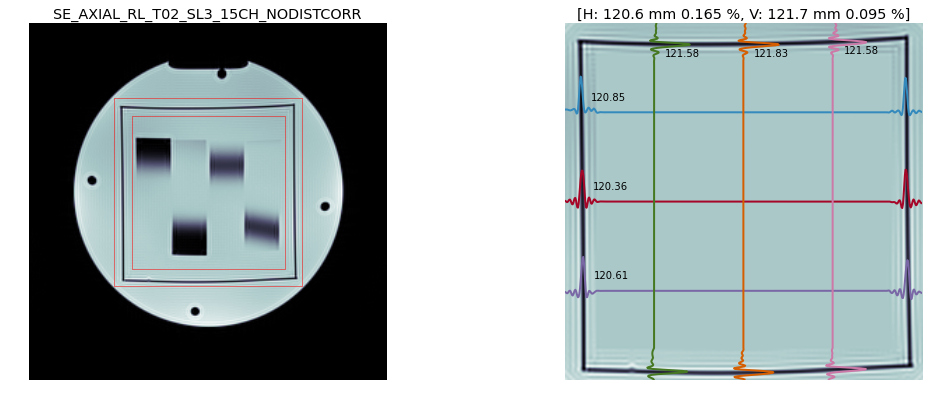

In [4]:
sernos = [43]
dobjs = fetch_series(patid, stuid, sernos)
slice_ = len(dobjs)//2
dobj = dobjs[slice_]
with plt.style.context('bmh'):
    result = distortion_report(dobj, flipped_ud=False, flipped_rl=False)
results = result

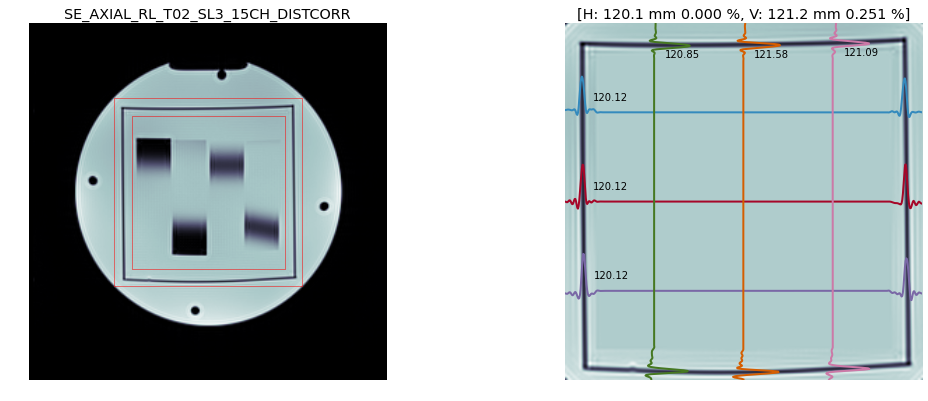

In [5]:
sernos = [45]
dobjs = fetch_series(patid, stuid, sernos)
slice_ = len(dobjs)//2
dobj = dobjs[slice_]
with plt.style.context('bmh'):
    result = distortion_report(dobj, flipped_ud=False, flipped_rl=False)
results = results.append(result)

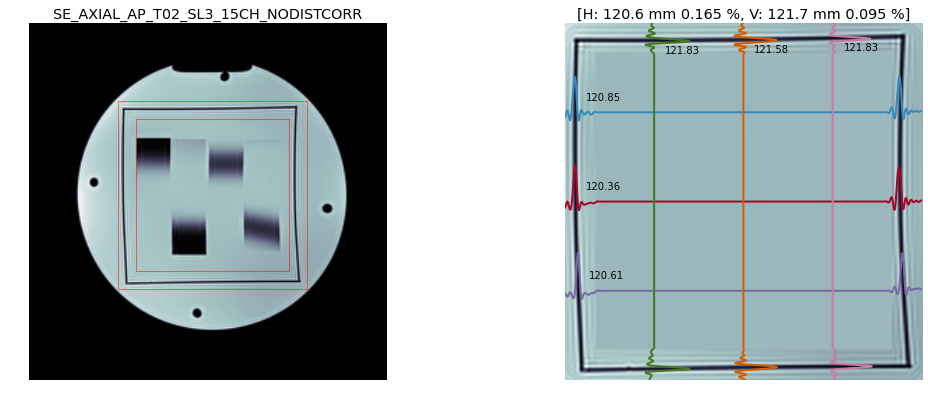

In [6]:
sernos = [53]
dobjs = fetch_series(patid, stuid, sernos)
slice_ = len(dobjs)//2
dobj = dobjs[slice_]
with plt.style.context('bmh'):
    result = distortion_report(dobj, flipped_ud=False, flipped_rl=False)
results = results.append(result)

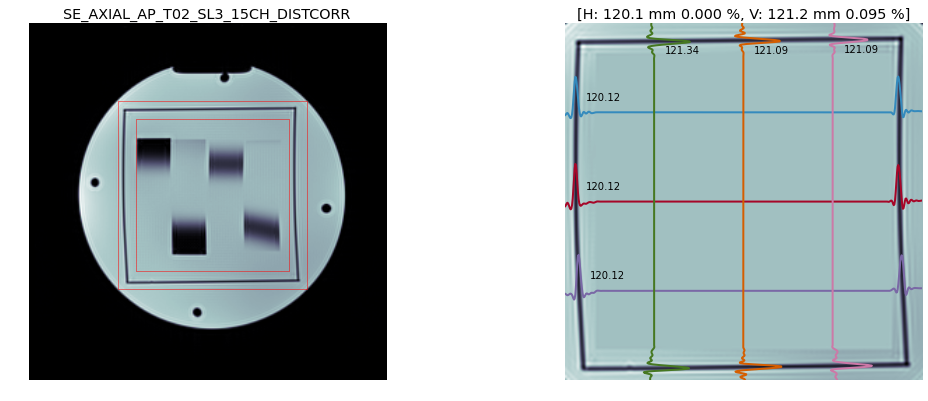

In [7]:
sernos = [55]
dobjs = fetch_series(patid, stuid, sernos)
slice_ = len(dobjs)//2
dobj = dobjs[slice_]
with plt.style.context('bmh'):
    result = distortion_report(dobj, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [8]:
pd.set_option('display.precision', 3)
display(results)

Protocol Orientation PhaseDirection  \
Series                                                                   
43      SE_AXIAL_RL_T02_SL3_15CH_NODISTCORR       Axial             RL   
45        SE_AXIAL_RL_T02_SL3_15CH_DISTCORR       Axial             RL   
53      SE_AXIAL_AP_T02_SL3_15CH_NODISTCORR       Axial             AP   
55        SE_AXIAL_AP_T02_SL3_15CH_DISTCORR       Axial             AP   

        HorizontalScale  HorizontalDistortion  VerticalScale  \
Series                                                         
43               120.61                  0.17         121.66   
45               120.12                  0.00         121.18   
53               120.61                  0.17         121.74   
55               120.12                  0.00         121.18   

        VerticalDistortion  
Series                      
43                    0.09  
45                    0.25  
53                    0.09  
55                    0.09